In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon
from skimage.transform import radon
from scipy.fft import fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

In [25]:
# === PARAMETERS ===
N = 256
pixel_size = 1e-6       # [m]
wavelength = 0.05e-9    # [m] (~25 keV)
z = 0.5                # [m] propagation distance (10 cm)

#=== MATERIAL PROPERTIES ===
delta = 5e-5           # refractive index decrement
beta = 1e-9             # absorption index
t = 50e-6               # thickness [m]
k = 2 * np.pi / wavelength


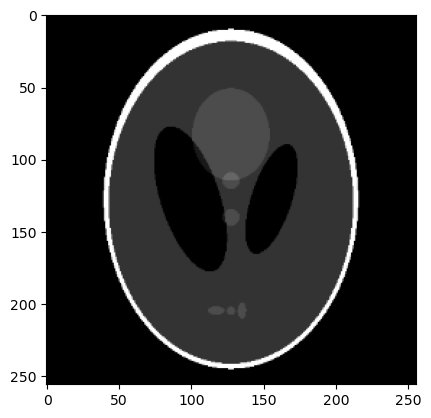

In [26]:
# === OBJECT DEFINITION (Shepp–Logan Phantom) ===
phantom = shepp_logan_phantom()           # standard phantom (256×256 grayscale)
image = resize(phantom, (N, N), mode='reflect', anti_aliasing=True)

# Optional normalization to [0, 1]
image = (image - image.min()) / (image.max() - image.min())
# Display the object
plt.imshow(image, cmap='gray')

In [27]:
# === WAVEFIELD TRANSMISSION THROUGH THE OBJECT ===
transmission = np.exp(-k * beta * t * image) * np.exp(1j * k * delta * t * image)   #THE FIRTS PART IS ABSORPTION, THE SECOND IS PHASE SHIFT

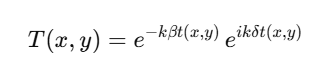

In [28]:
# === INTENSITY AFTER THE OBJECT (ABSORPTION ONLY) ===
I_abs = np.abs(transmission)**2

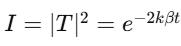

In [29]:
# === PROPAGATION (Angular Spectrum) ===
# The propagation from the object to the detector is modeled by multiplying the Fourier transform of the wavefield by a transfer function 

fx = np.fft.fftfreq(N, pixel_size)
fy = np.fft.fftfreq(N, pixel_size)
FX, FY = np.meshgrid(fx, fy)
arg = 1.0 - (wavelength * FX)**2 - (wavelength * FY)**2
sqrt_term = np.sqrt(np.clip(arg, 0.0, None))
H = np.exp(1j * 2 * np.pi * z / wavelength * sqrt_term)
wave = np.fft.ifft2(np.fft.fft2(transmission) * H)
I_phase = np.abs(wave)**2  # Intensità dopo propagazione (PBI)

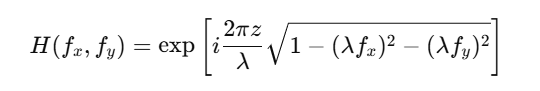

In [30]:
# Check the intensity variation
print(f"I_phase mean: {I_phase.mean()}")
print(f"I_phase std: {I_phase.std()}")
print(f"I_phase range: [{I_phase.min()}, {I_phase.max()}]")
print(f"Contrast: {I_phase.std() / I_phase.mean()}")

# The contrast should be > 0.01 for visible features
# If contrast is very small (~1e-6), phase effects are negligible

I_phase mean: 0.9984582376476228
I_phase std: 0.30463585042365815
I_phase range: [0.0007266865500846578, 5.789996040467365]
Contrast: 0.30510625175609063


In [31]:
# === 1D PROFILES ===
row = N // 2
x_axis = (np.arange(N) - N/2) * pixel_size * 1e6  # [µm]
I_abs_profile = I_abs[row, :]
I_phase_profile = I_phase[row, :]


# --------------------- Absorption sinogram ---------------------
theta = np.linspace(0., 180., 180, endpoint=False)
# Standard Beer-Lambert: line integral of mu
sinogram_abs = radon(-np.log(np.clip(I_abs, 1e-12, None)),
                     theta=theta, circle=False)

# --------------------- Phase contrast sinogram ---------------------
def paganin_phase_retrieval(I, delta_over_beta, z, wavelength, dx):
    """
    Simple single-distance Paganin phase retrieval for 2D propagation-based phase contrast
    I = propagated intensity
    Returns retrieved projected phase (line integral of delta)
    """
    Nx, Ny = I.shape
    fx = np.fft.fftfreq(Nx, dx)
    fy = np.fft.fftfreq(Ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    # Paganin filter in Fourier domain
    H = 1.0 / (1.0 + (wavelength * z / (4*np.pi*delta_over_beta)) * (FX**2 + FY**2))

    # Apply filter
    I_log = -np.log(np.clip(I, 1e-12, None))
    I_fft = fft2(I_log)
    phi_retrieved = np.real(ifft2(I_fft * H))
    return phi_retrieved

# Apply phase retrieval
delta_over_beta = delta / beta
proj_phase = paganin_phase_retrieval(I_phase, delta_over_beta, z, wavelength, pixel_size)

# Radon transform gives sinogram of projected phase
sinogram_phase = radon(proj_phase, theta=theta, circle=False)

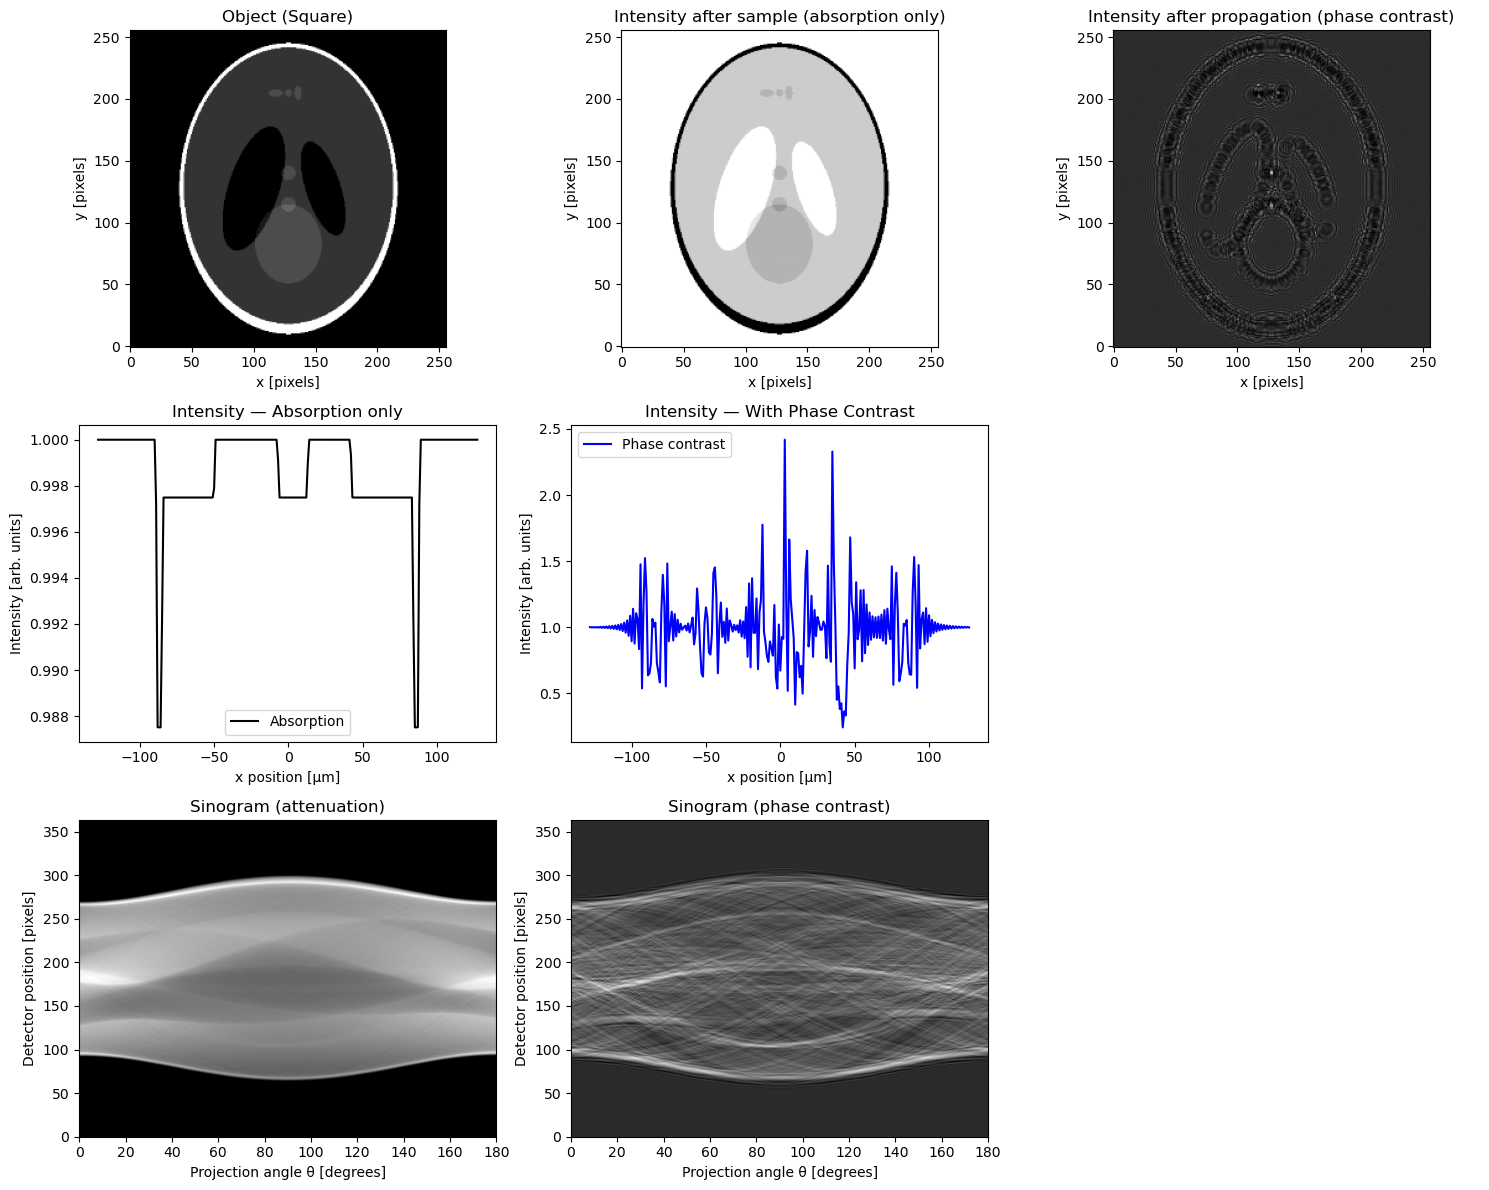

In [32]:
# === VISUALISATION ===
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# OBJECT
axes[0,0].imshow(image, cmap='gray', origin='lower')
axes[0,0].set_title("Object (Square)")
axes[0,0].set_xlabel("x [pixels]")
axes[0,0].set_ylabel("y [pixels]")

# 2D INTENSITY
axes[0,1].imshow(I_abs, cmap='gray', origin='lower')
axes[0,1].set_title("Intensity after sample (absorption only)")
axes[0,1].set_xlabel("x [pixels]")
axes[0,1].set_ylabel("y [pixels]")

axes[0,2].imshow(I_phase, cmap='gray', origin='lower')
axes[0,2].set_title("Intensity after propagation (phase contrast)")
axes[0,2].set_xlabel("x [pixels]")
axes[0,2].set_ylabel("y [pixels]")

# 1D PROFILES
axes[1,0].plot(x_axis, I_abs_profile, 'k', label="Absorption")
axes[1,0].set_title("Intensity — Absorption only")
axes[1,0].set_xlabel("x position [µm]")
axes[1,0].set_ylabel("Intensity [arb. units]")
axes[1,0].legend()

axes[1,1].plot(x_axis, I_phase_profile, 'b', label="Phase contrast")
axes[1,1].set_title("Intensity — With Phase Contrast")
axes[1,1].set_xlabel("x position [µm]")
axes[1,1].set_ylabel("Intensity [arb. units]")
axes[1,1].legend()

axes[1,2].axis('off')

# SINOGRAMS
axes[2,0].imshow(sinogram_abs, cmap='gray', 
                  extent=(0, 180, 0, sinogram_abs.shape[0]), aspect='auto', origin='lower')
axes[2,0].set_title("Sinogram (attenuation)")
axes[2,0].set_xlabel("Projection angle θ [degrees]")
axes[2,0].set_ylabel("Detector position [pixels]")

axes[2,1].imshow(sinogram_phase, cmap='gray', 
                  extent=(0, 180, 0, sinogram_phase.shape[0]), aspect='auto', origin='lower')
axes[2,1].set_title("Sinogram (phase contrast)")
axes[2,1].set_xlabel("Projection angle θ [degrees]")
axes[2,1].set_ylabel("Detector position [pixels]")

axes[2,2].axis('off')

plt.tight_layout()
plt.show()


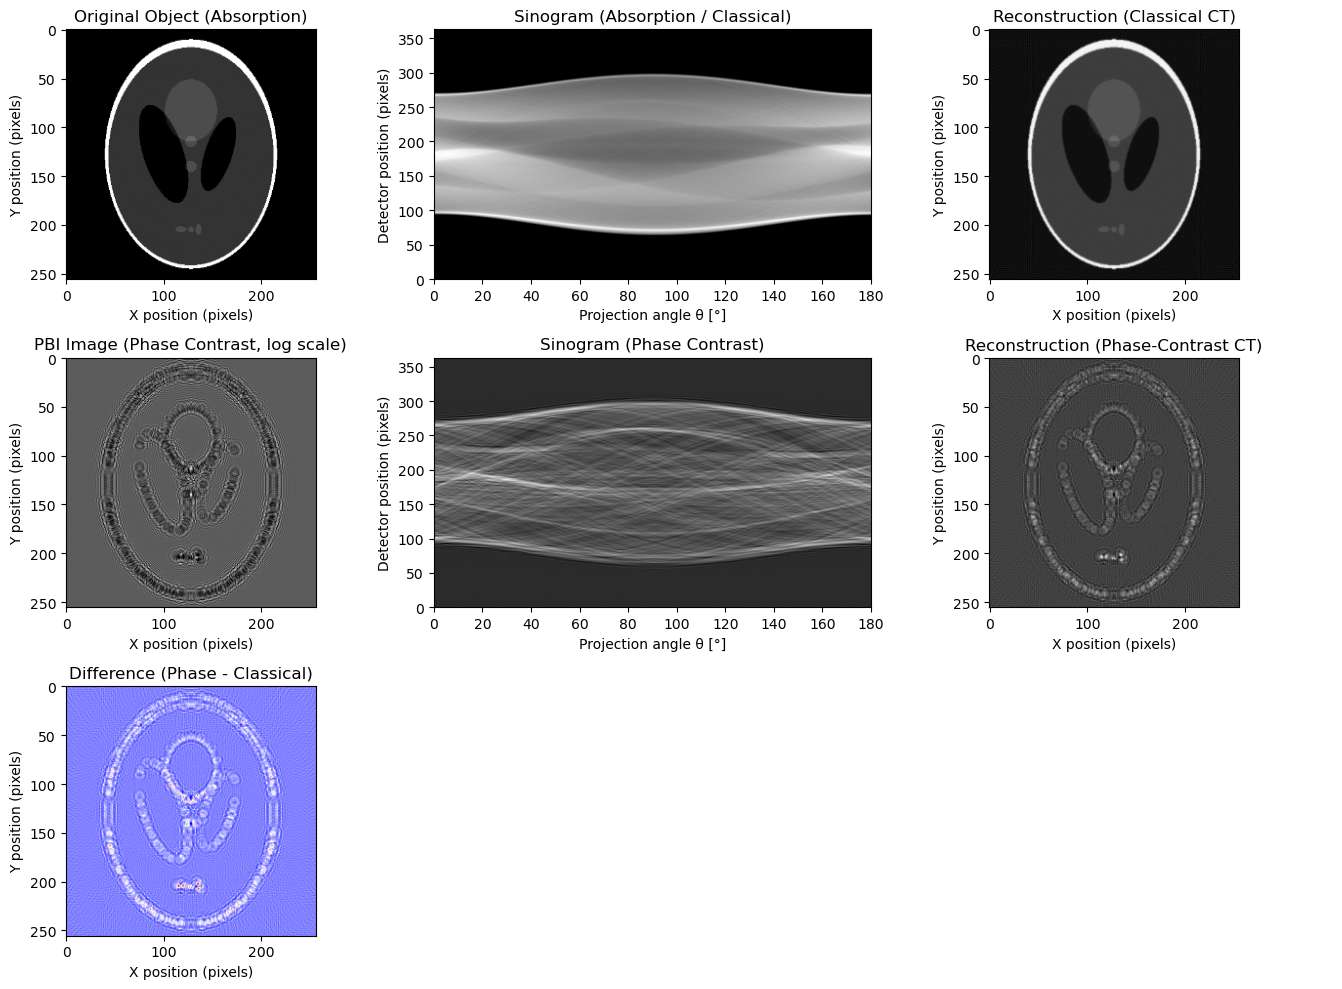

In [33]:
from skimage.transform import radon, iradon
import matplotlib.pyplot as plt
import numpy as np

# === RECONSTRUCTION FROM SINOGRAMS ===
recon_abs = iradon(sinogram_abs, theta=theta, circle=False, filter_name='ramp')
recon_phase = iradon(sinogram_phase, theta=theta, circle=False, filter_name='ramp')

# === VISUALIZATION: ORIGINAL IMAGES, SINOGRAMS, AND RECONSTRUCTIONS ===
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

# --- Absorption CT (classical) ---
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Original Object (Absorption)")
axes[0, 0].set_xlabel("X position (pixels)")
axes[0, 0].set_ylabel("Y position (pixels)")

axes[0, 1].imshow(sinogram_abs, cmap='gray',
                  extent=(0, 180, 0, sinogram_abs.shape[0]), aspect='auto')
axes[0, 1].set_title("Sinogram (Absorption / Classical)")
axes[0, 1].set_xlabel("Projection angle θ [°]")
axes[0, 1].set_ylabel("Detector position (pixels)")

axes[0, 2].imshow(recon_abs, cmap='gray')
axes[0, 2].set_title("Reconstruction (Classical CT)")
axes[0, 2].set_xlabel("X position (pixels)")
axes[0, 2].set_ylabel("Y position (pixels)")

# --- Phase-Contrast CT (PBI) ---
axes[1, 0].imshow(np.log1p(I_phase), cmap='gray')
axes[1, 0].set_title("PBI Image (Phase Contrast, log scale)")
axes[1, 0].set_xlabel("X position (pixels)")
axes[1, 0].set_ylabel("Y position (pixels)")

axes[1, 1].imshow(sinogram_phase, cmap='gray',
                  extent=(0, 180, 0, sinogram_phase.shape[0]), aspect='auto')
axes[1, 1].set_title("Sinogram (Phase Contrast)")
axes[1, 1].set_xlabel("Projection angle θ [°]")
axes[1, 1].set_ylabel("Detector position (pixels)")

axes[1, 2].imshow(recon_phase, cmap='gray')
axes[1, 2].set_title("Reconstruction (Phase-Contrast CT)")
axes[1, 2].set_xlabel("X position (pixels)")
axes[1, 2].set_ylabel("Y position (pixels)")

# --- Difference between reconstructions ---
axes[2, 0].imshow(recon_phase - recon_abs, cmap='bwr')
axes[2, 0].set_title("Difference (Phase - Classical)")
axes[2, 0].set_xlabel("X position (pixels)")
axes[2, 0].set_ylabel("Y position (pixels)")

axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()
